# Advanced Exploratory Data Analysis

**Goal:** To dive deeper into the maize yield dataset. We will:
1.  Inspect all variables within the dataset.
2.  Create Europe-centric maps.
3.  Visualize yield changes over time with a series of maps.
4.  Add country borders for better context.

In [1]:
# Cell 1: Imports and Data Loading
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

# New imports for advanced mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
DATA_PATH = '../data/maize_major/yield_*.nc4'

# --- Load Data ---
# Same loading logic as before
try:
    ds = xr.open_mfdataset(DATA_PATH, combine='nested', concat_dim='time')
    filepaths = sorted(glob.glob(DATA_PATH))
    years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
    ds = ds.assign_coords(time=years)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset loaded successfully.


## 1. Are there other variables in the dataset?

Let's inspect the full structure of the loaded `xarray.Dataset` to see all coordinates, dimensions, and data variables it contains.

In [2]:
# Cell 2: Inspecting the Dataset Contents
print(ds)

<xarray.Dataset> Size: 37MB
Dimensions:  (time: 36, lat: 360, lon: 720)
Coordinates:
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) int64 288B 1981 1982 1983 1984 1985 ... 2013 2014 2015 2016
Data variables:
    var      (time, lat, lon) float32 37MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>


## 2. Creating a Better Map: Europe-Centric with Borders

The default map centers on the Pacific Ocean (0 longitude). We can use `cartopy` to create a new map centered on Europe and overlay country borders for better geographical context.

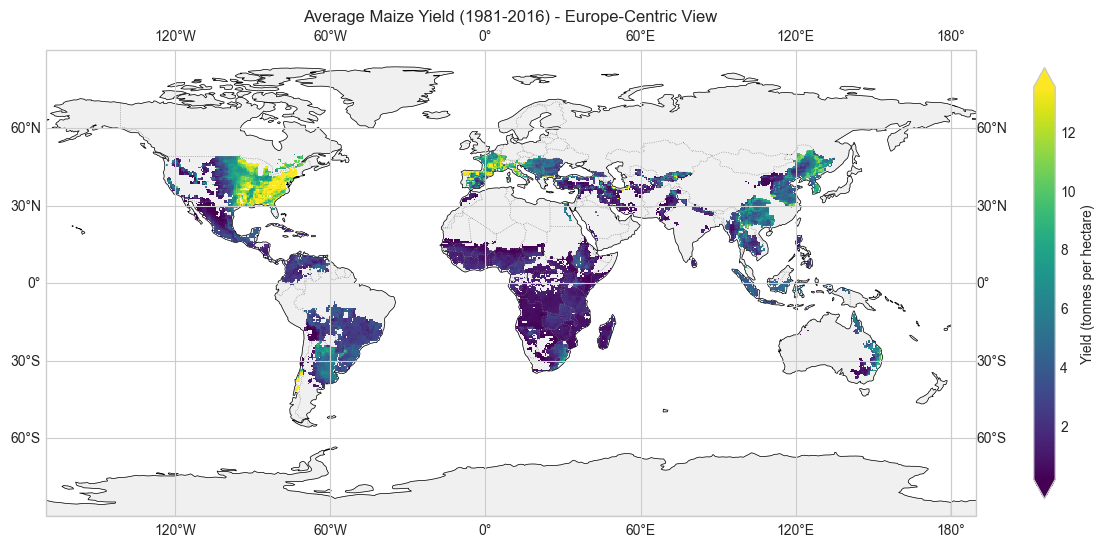

In [7]:
# Cell 3 (New, Corrected): Europe-Centric Map with Improved Styling

# Calculate the mean yield map, same as before
maize_yield = ds['var']
mean_yield_map = maize_yield.mean(dim='time').where(maize_yield.mean(dim='time') > 0)

# --- Create the Plot ---
# Create the figure and axes with a Cartopy projection centered on Europe
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})

# --- Style the Map Background (Applying the new style) ---
# Add a light grey land feature and very thin borders
ax.add_feature(cfeature.LAND, edgecolor='lightgray', facecolor='#f0f0f0', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)
ax.coastlines(linewidth=0.5)

# --- Plot the Data ---
mean_yield_map.plot(
    ax=ax,
    cmap='viridis',
    robust=True, # robust=True is fine for a single map
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'shrink': 0.7, 'label': 'Yield (tonnes per hectare)'}
)

# Add gridlines for reference
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.set_title('Average Maize Yield (1981-2016) - Europe-Centric View')
plt.show()

## 3. Visualizing Yield Evolution: A Yearly Map Series

To see the changes more clearly, let's create a series of large maps, one for each year in the dataset. We will use lighter map features to ensure the data stands out.

C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


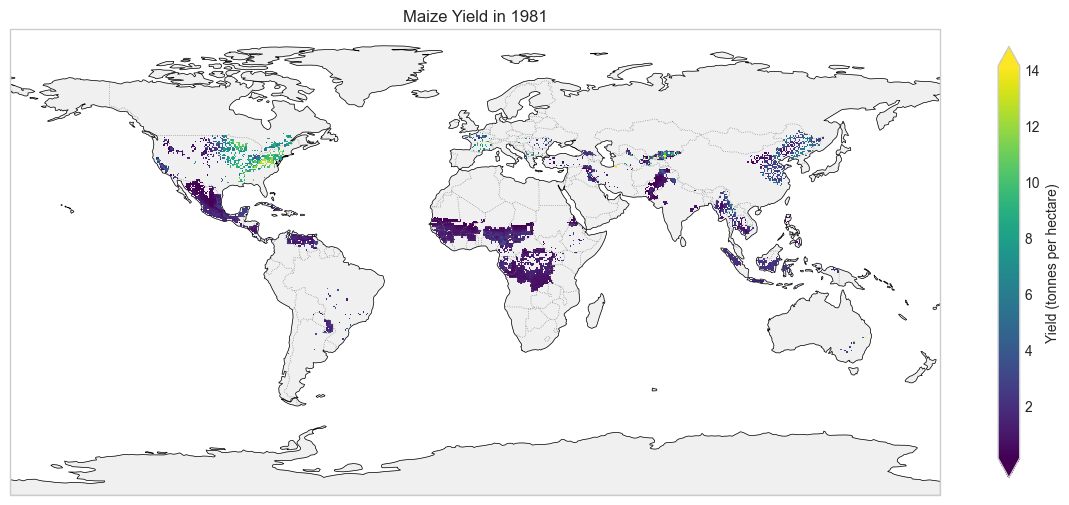

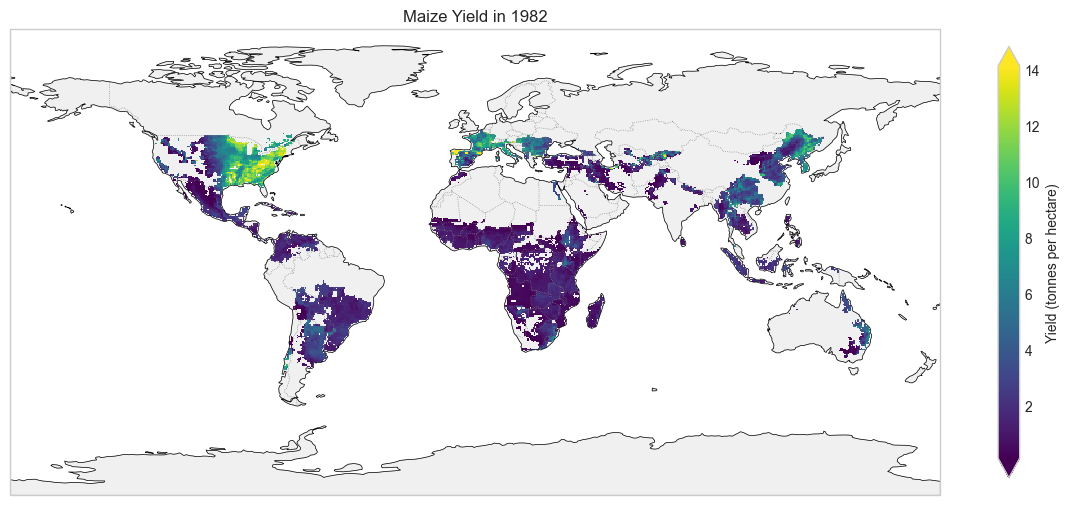

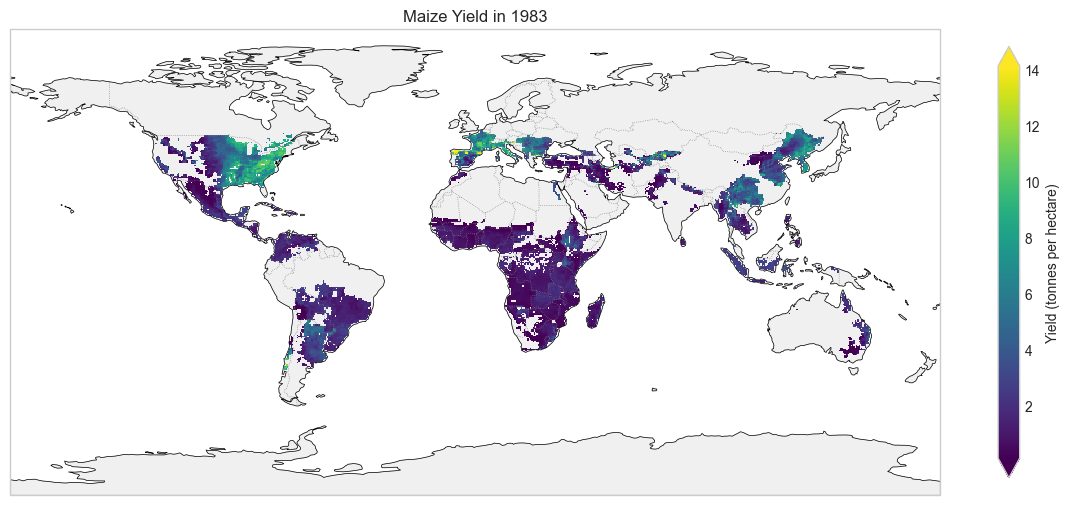

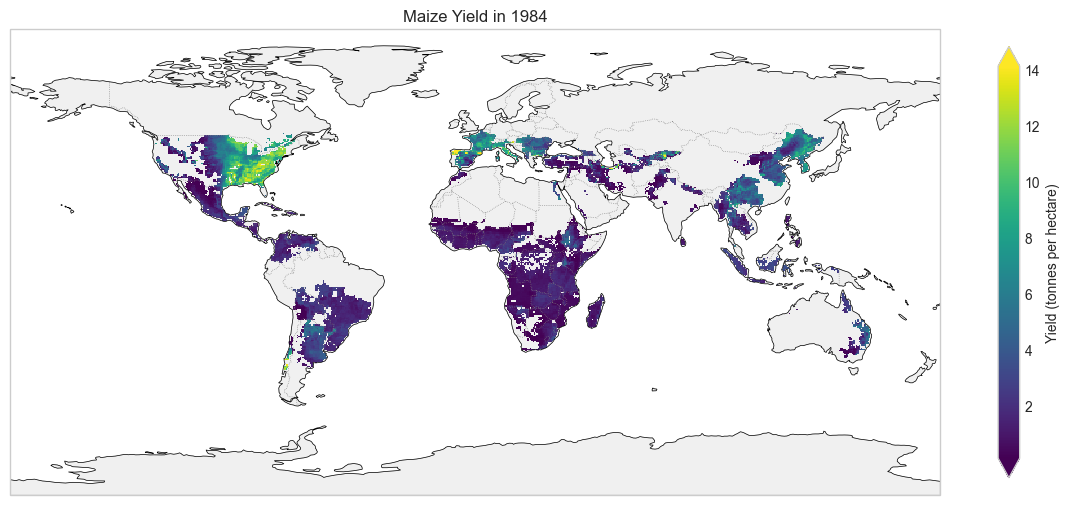

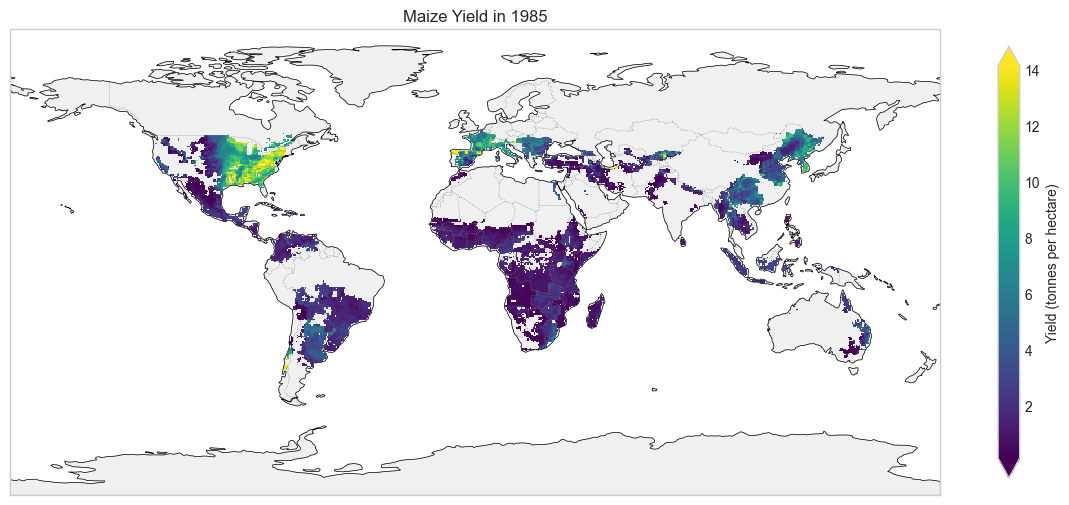

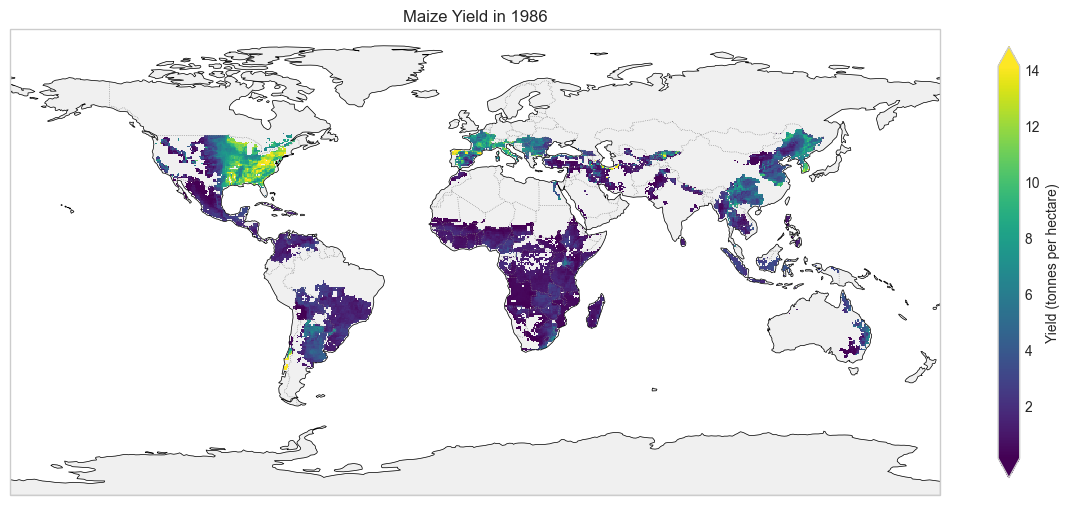

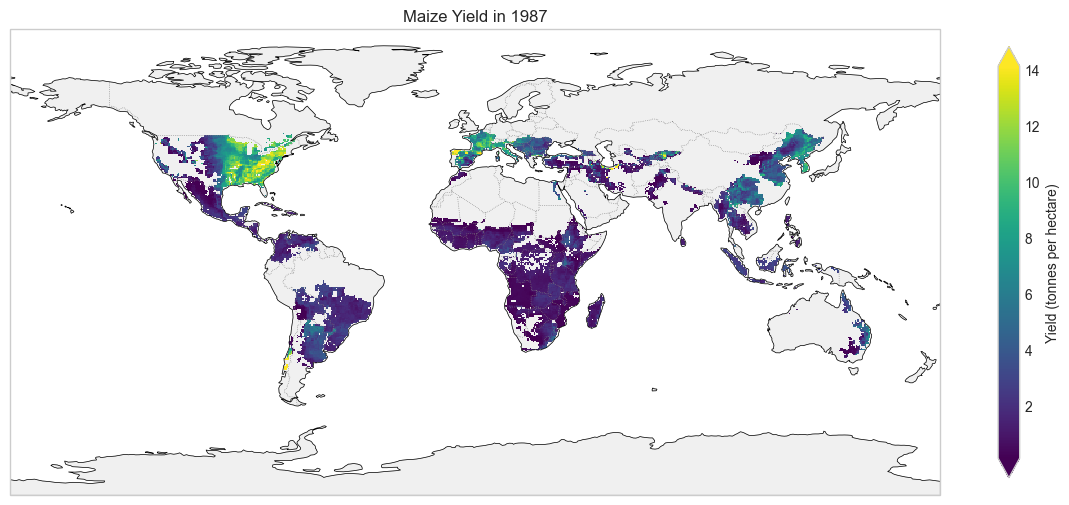

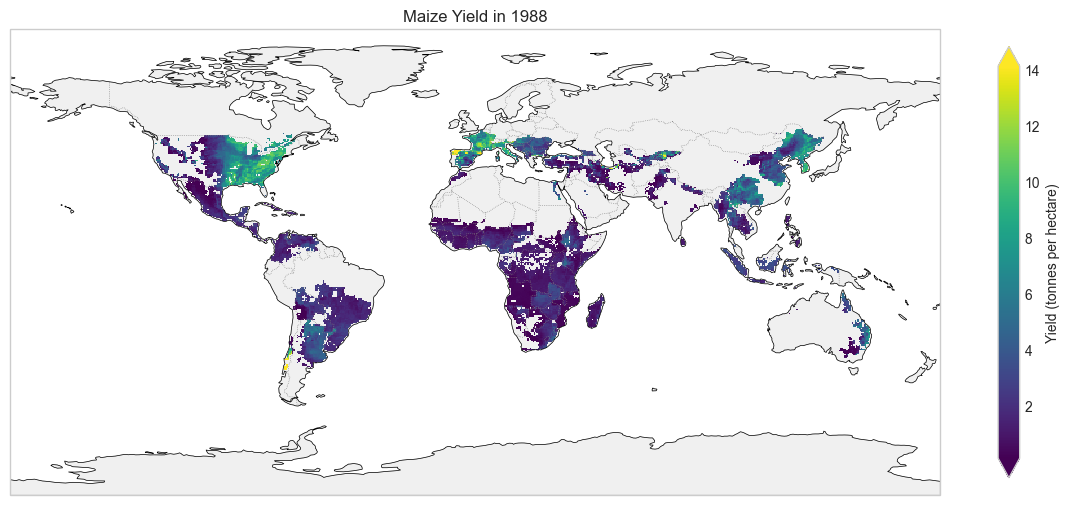

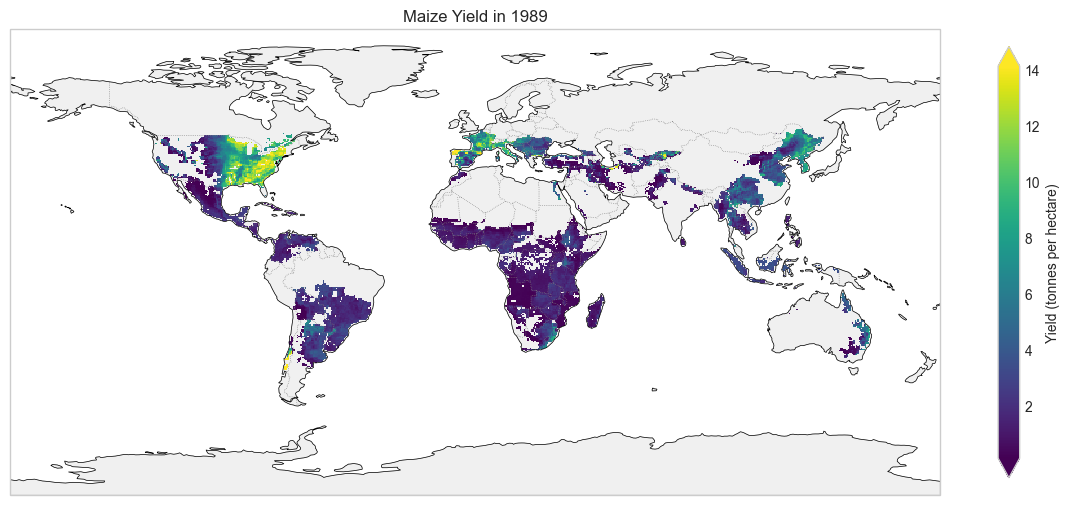

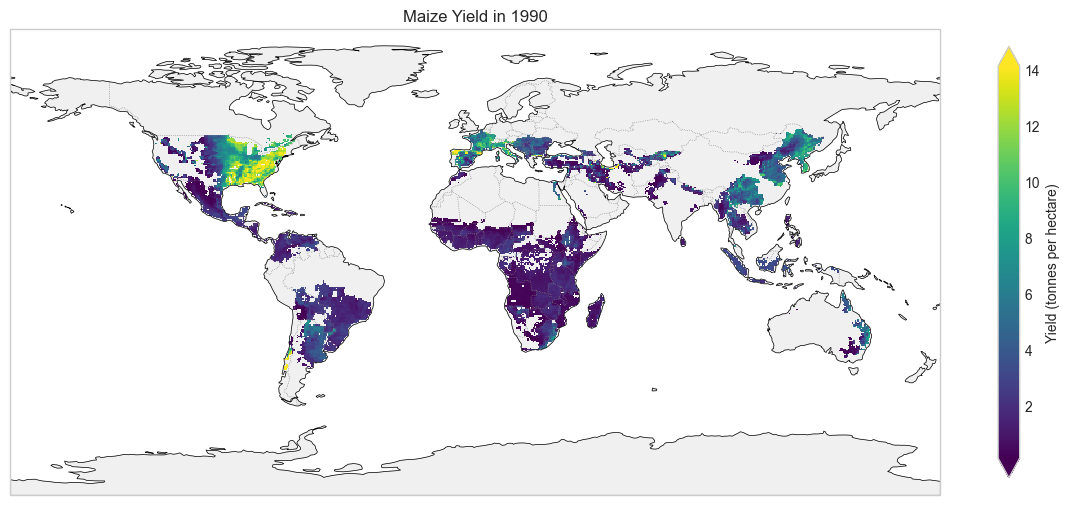

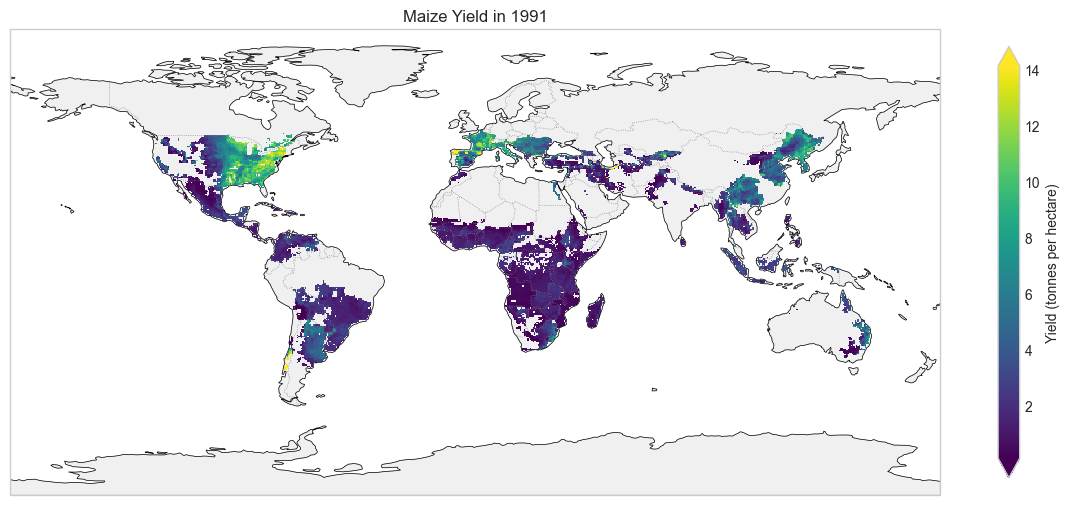

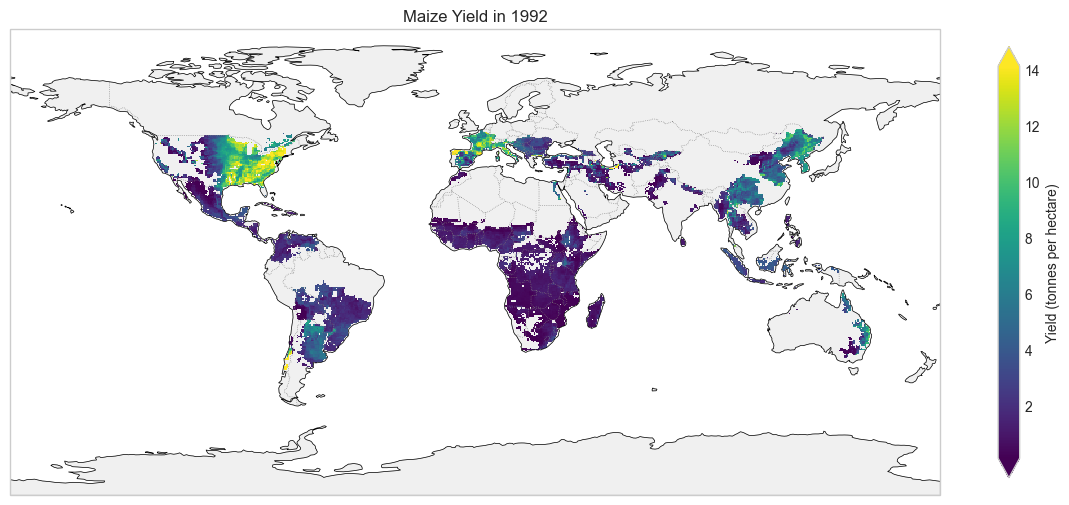

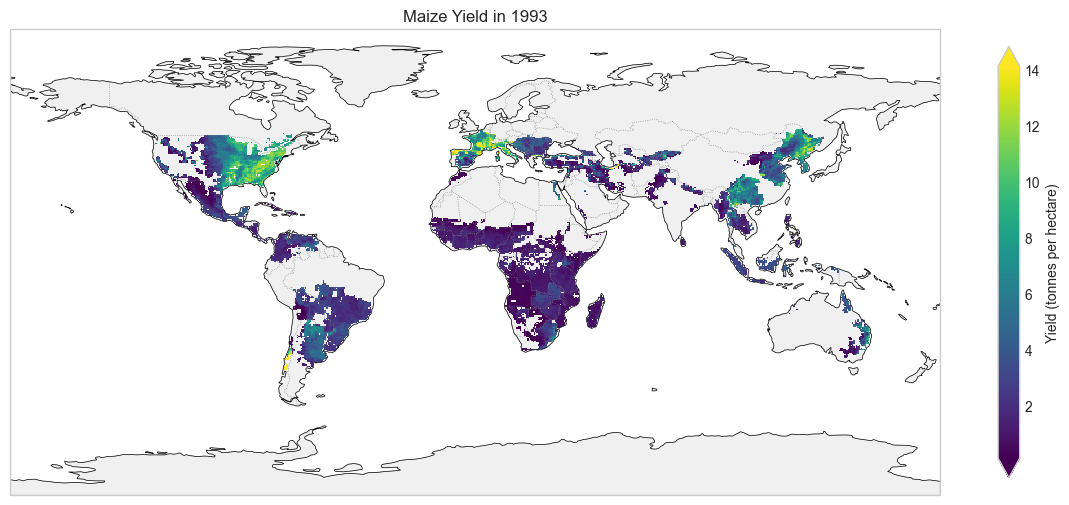

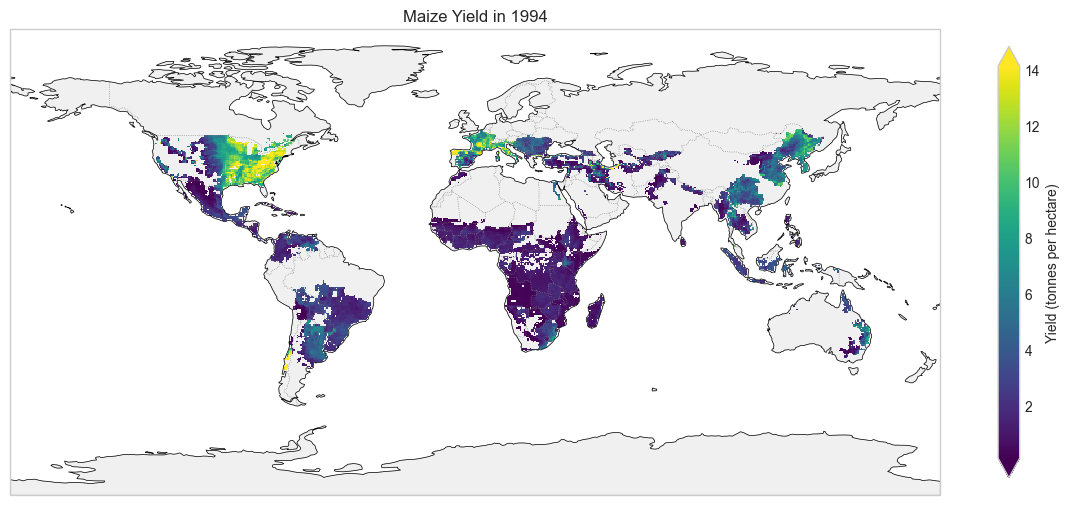

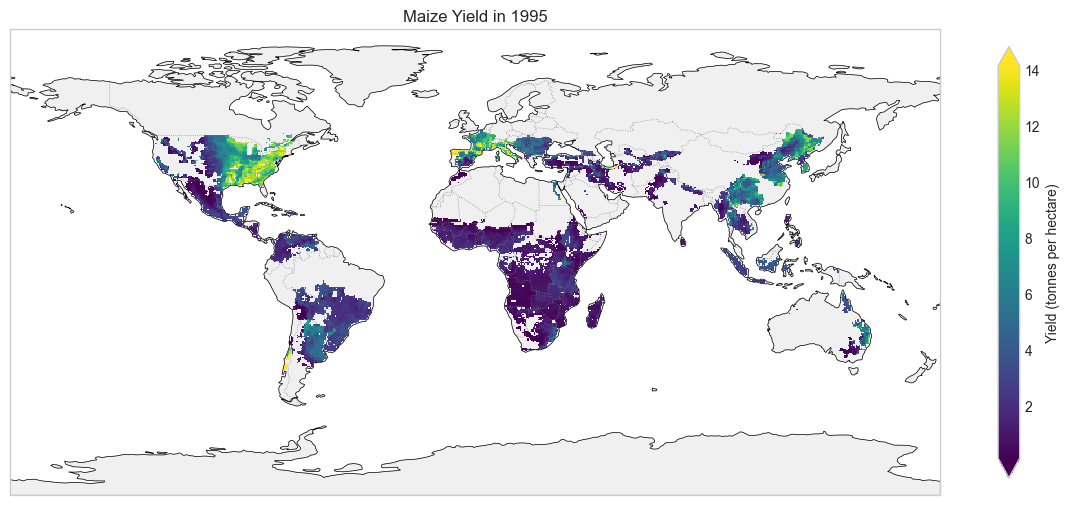

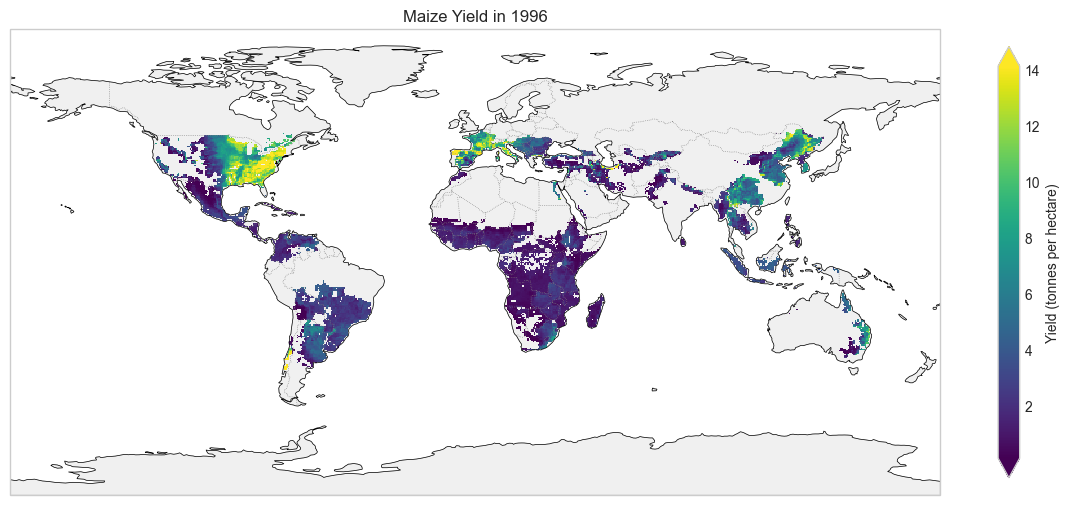

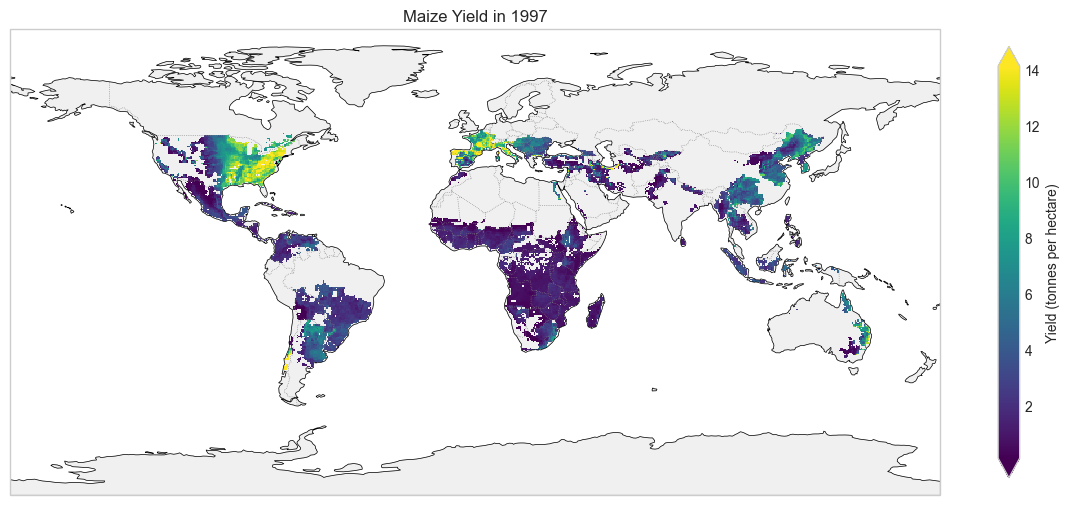

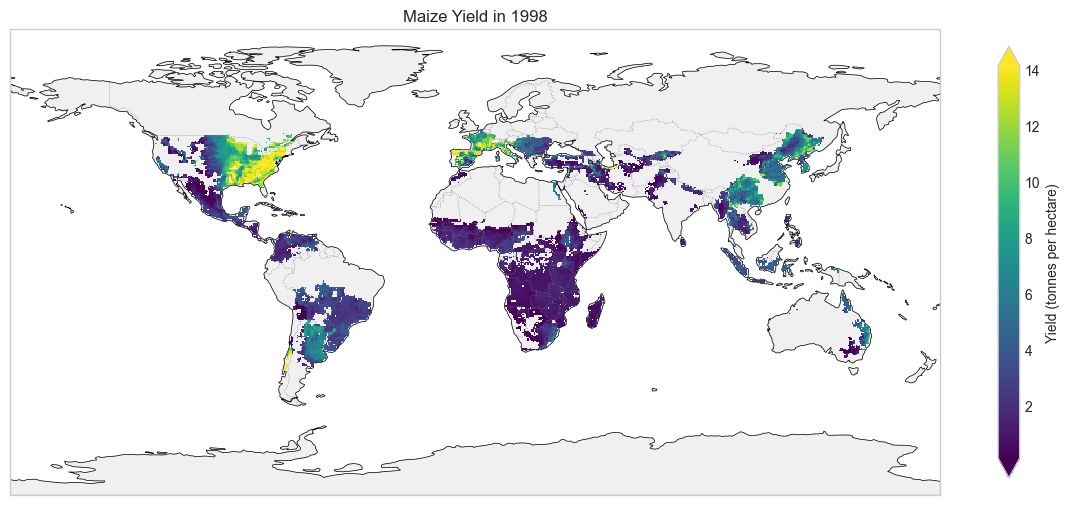

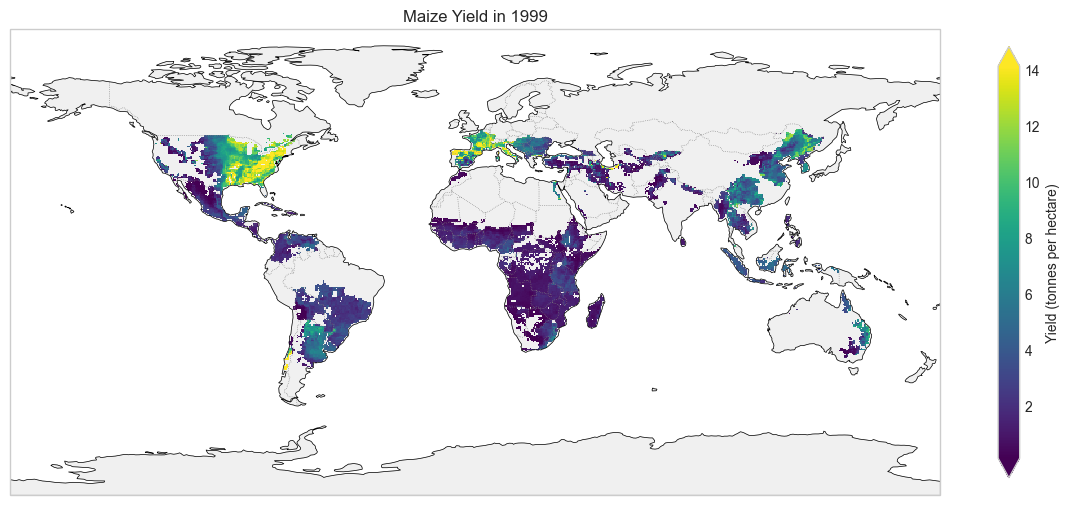

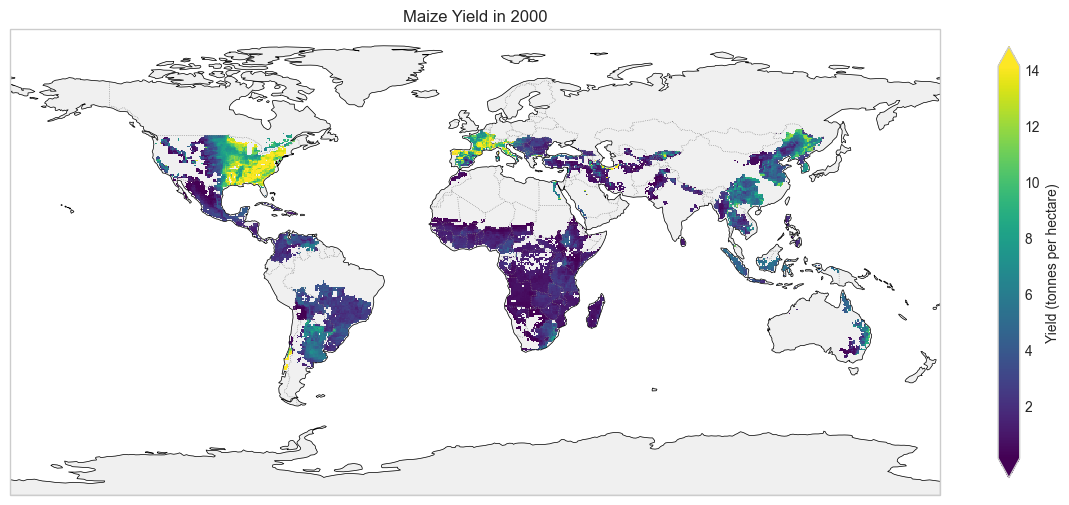

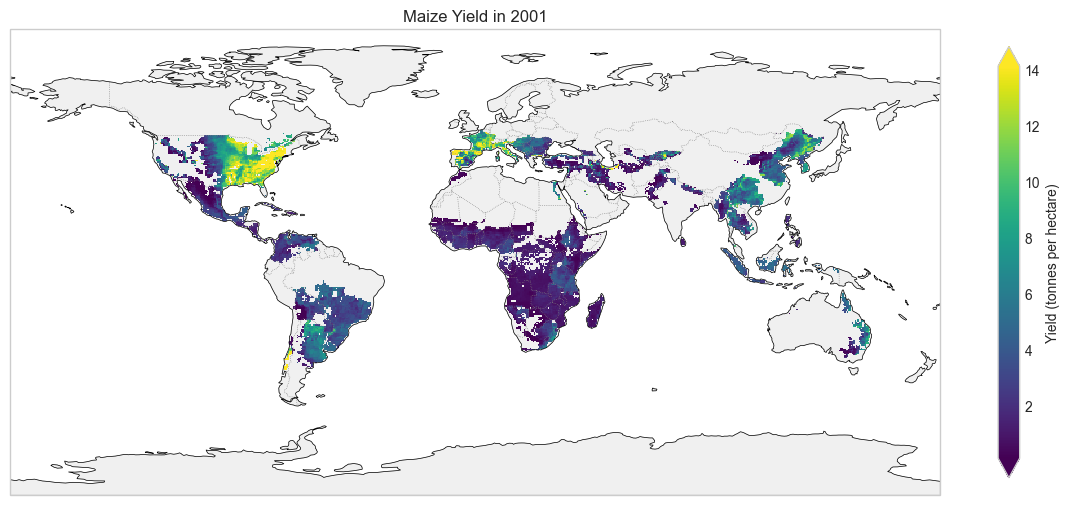

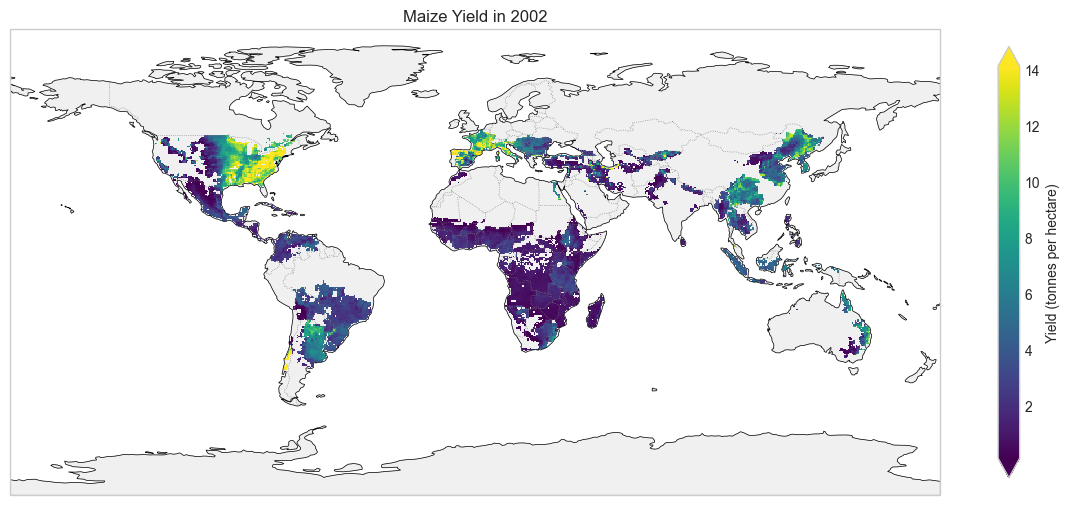

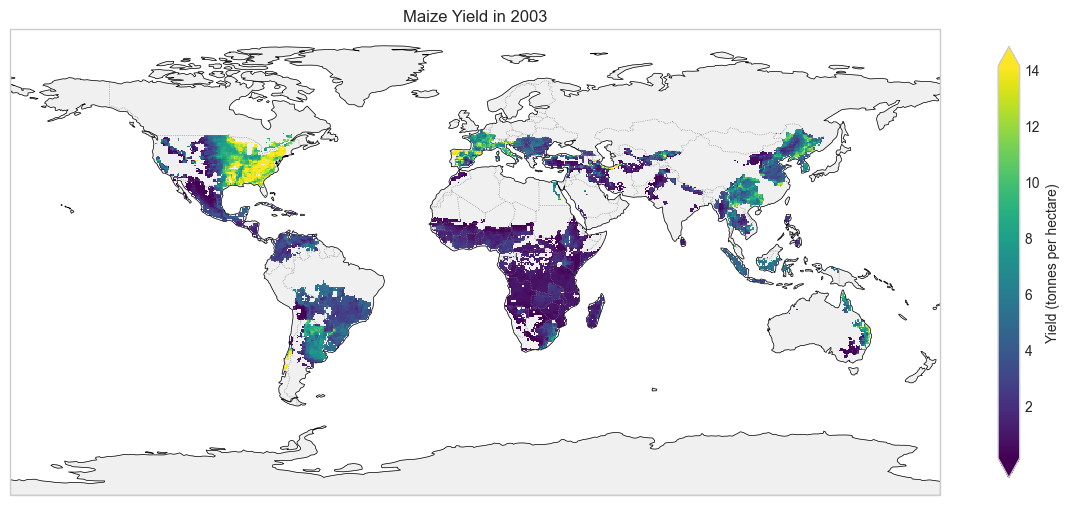

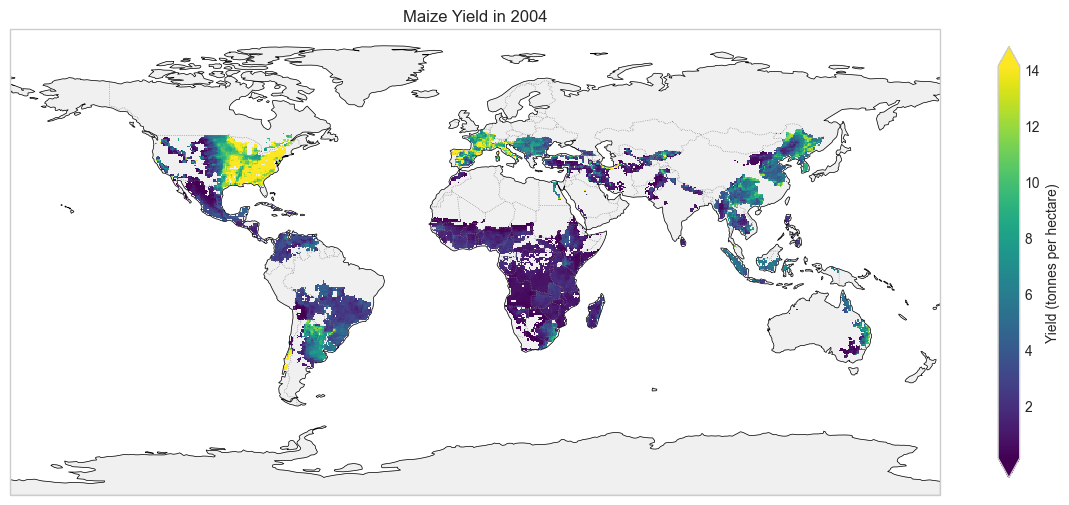

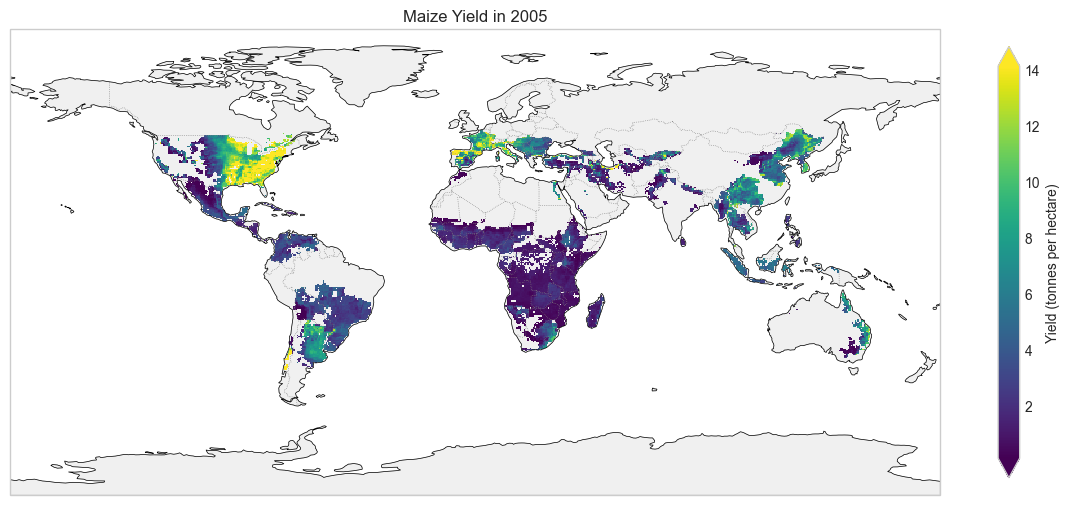

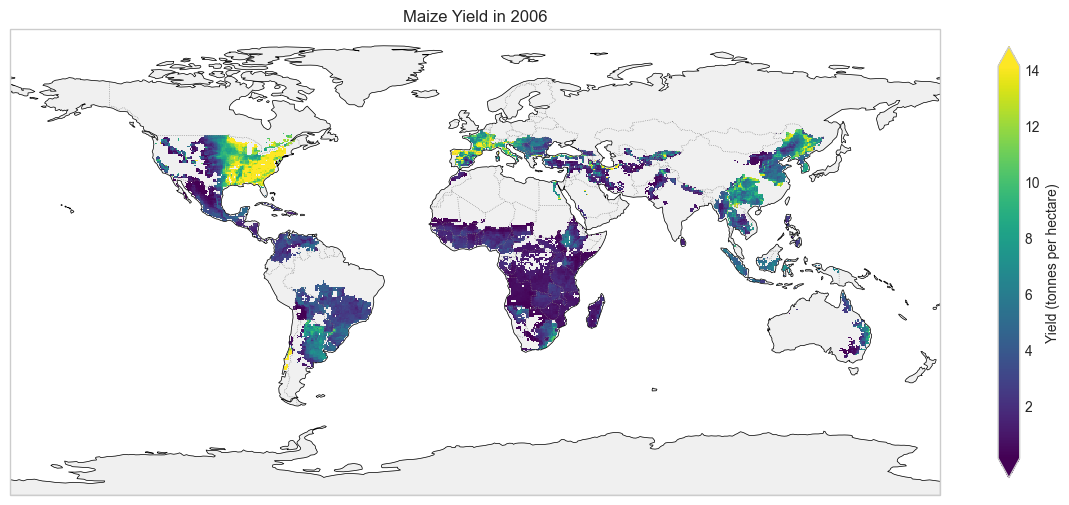

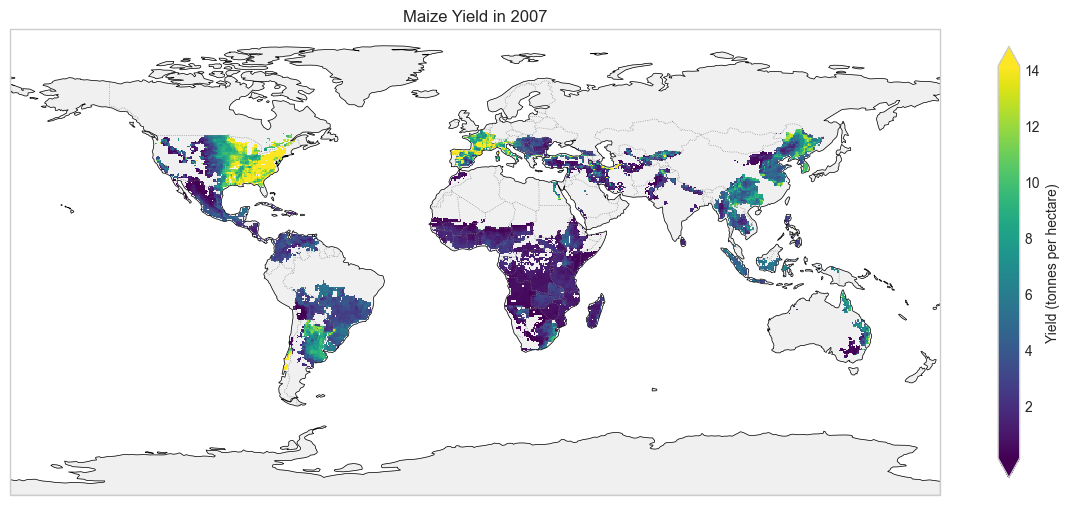

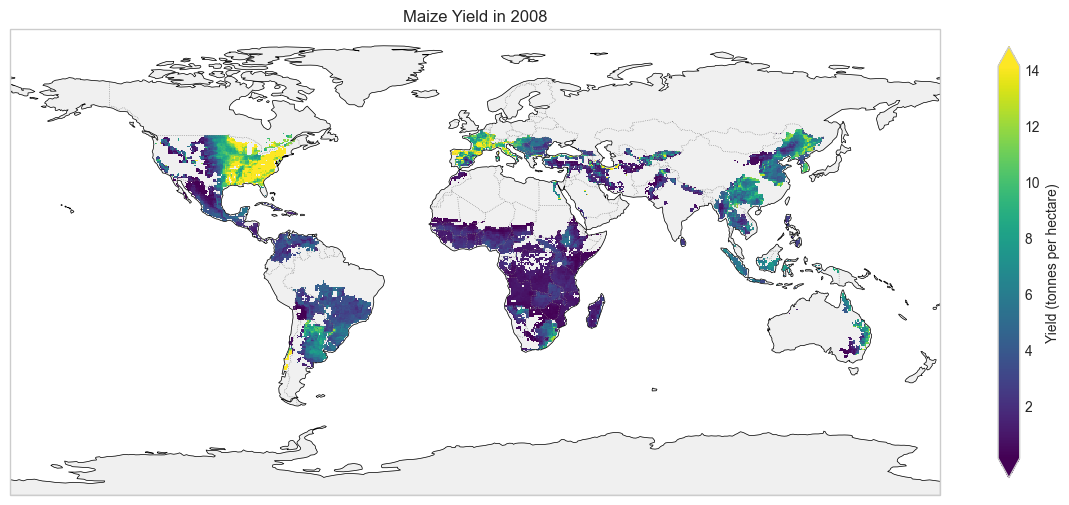

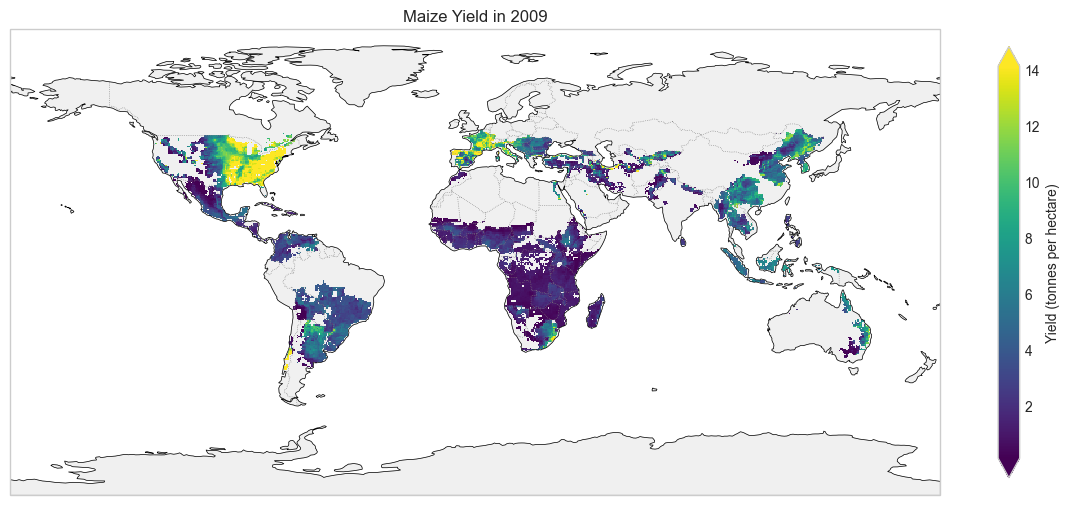

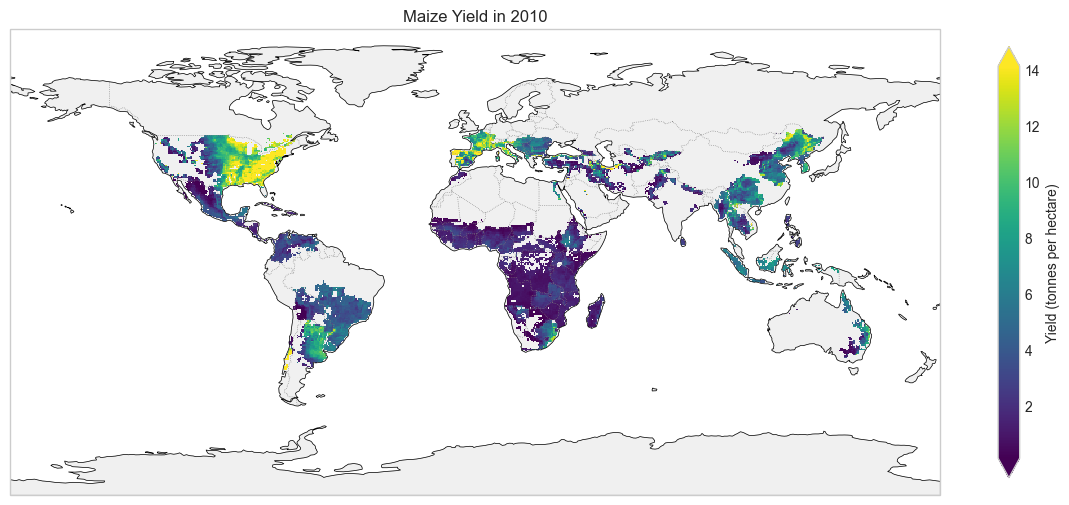

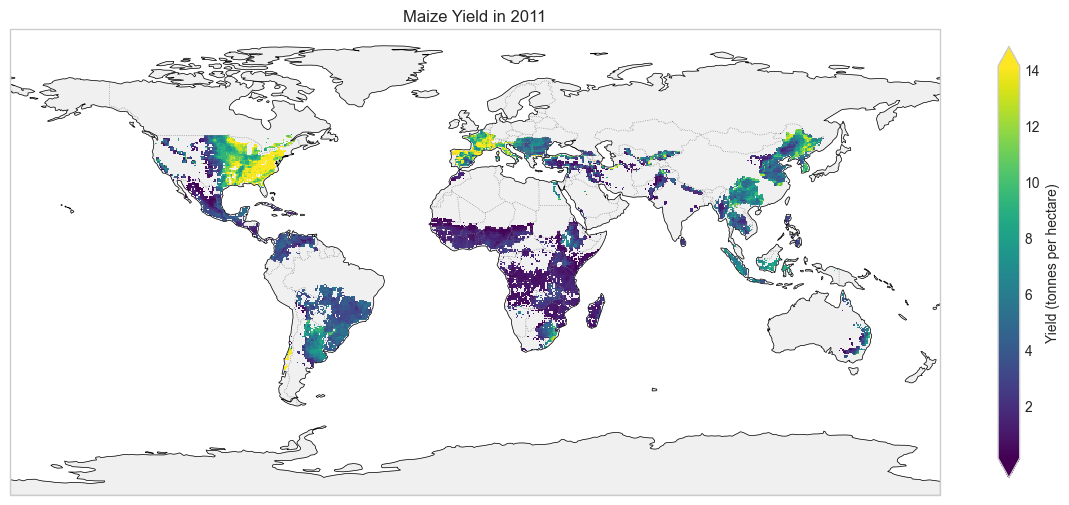

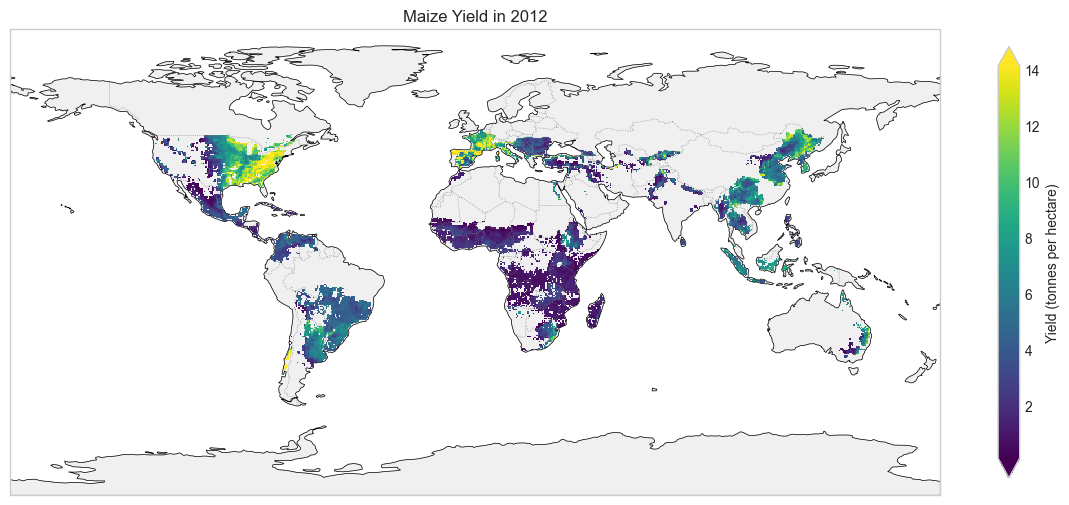

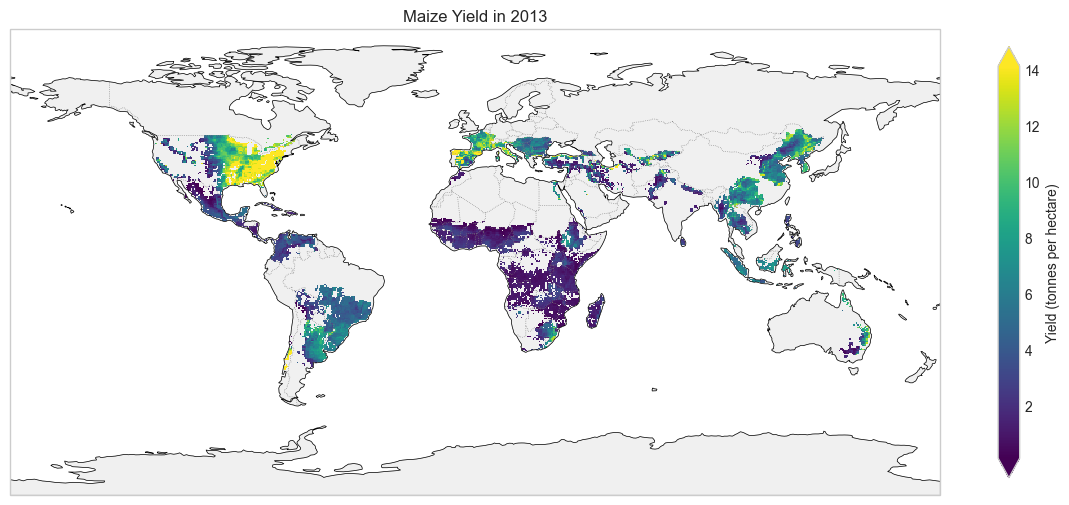

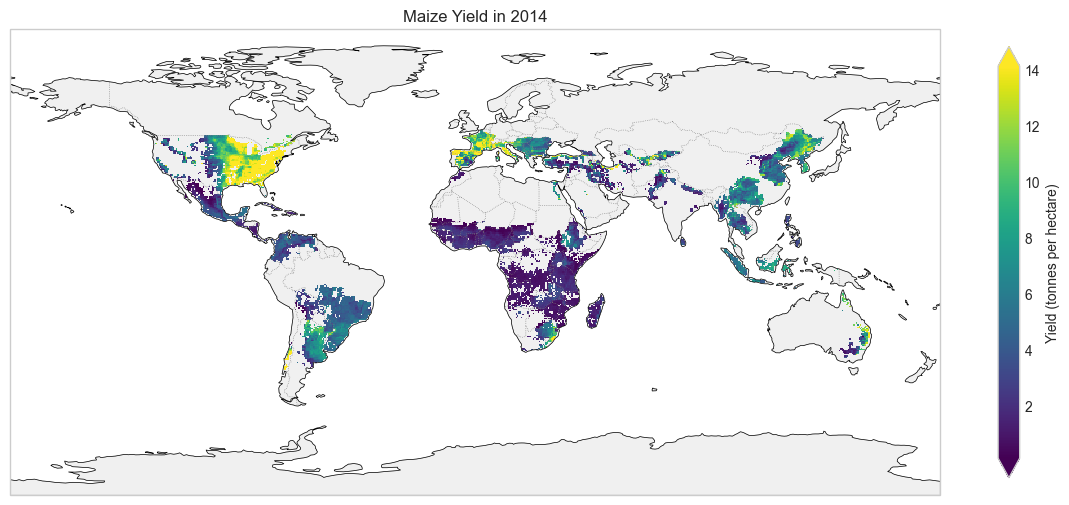

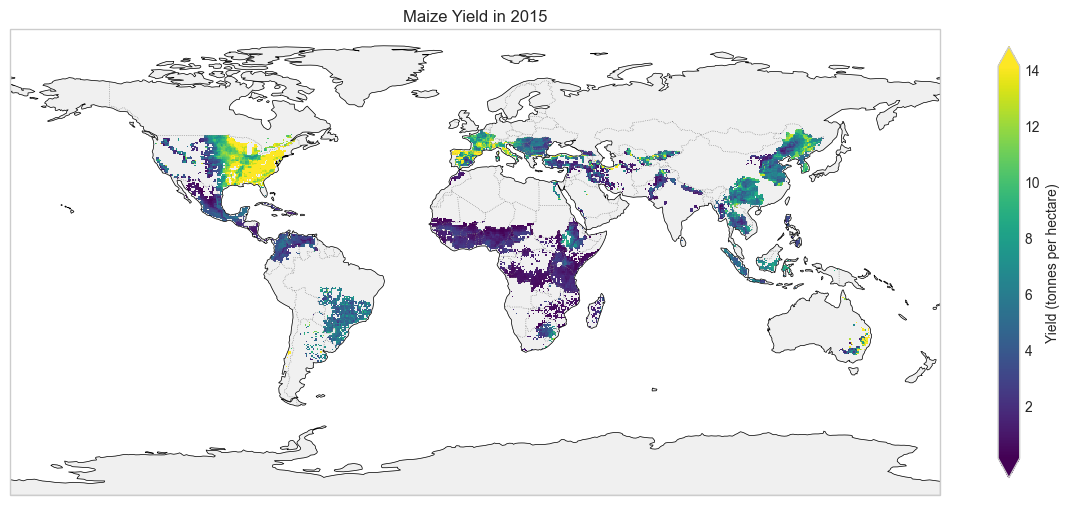

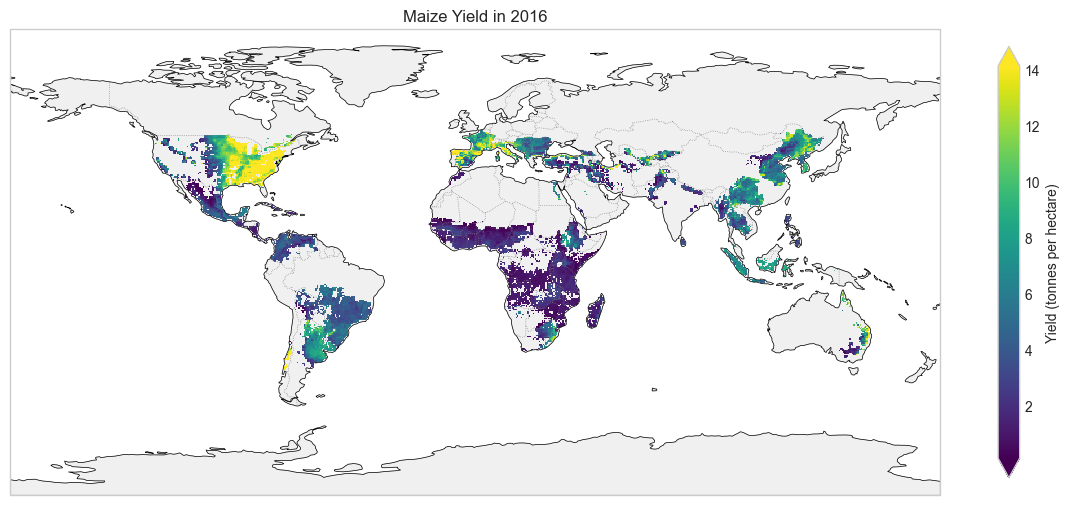

In [6]:
# Cell 4 (New, Corrected): Yearly Map Series

# To ensure the color scale is consistent across all maps, we'll calculate the
# min and max yield values to use for the color bar.
# Using the 2nd and 98th percentiles (like robust=True does) makes for a better visualization.
# We add .compute() to force dask to actually calculate the value.
vmin = maize_yield.quantile(0.02).compute().item()
vmax = maize_yield.quantile(0.98).compute().item()

# Loop through each year in the dataset's time coordinate
for year in ds['time'].values:
    
    # Select the data for the current year in the loop
    yield_for_one_year = maize_yield.sel(time=year).where(maize_yield.sel(time=year) > 0)
    
    # --- Create the Plot ---
    # We create a new figure and axes for each year
    fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # --- Style the Map Background (Your Request) ---
    # Add a light grey land feature and very thin borders
    ax.add_feature(cfeature.LAND, edgecolor='lightgray', facecolor='#f0f0f0', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)
    ax.coastlines(linewidth=0.5)

    # --- Plot the Data ---
    yield_for_one_year.plot(
        ax=ax,
        cmap='viridis',
        transform=ccrs.PlateCarree(),
        vmin=vmin,  # Use the consistent min/max for the color scale
        vmax=vmax,
        cbar_kwargs={'shrink': 0.7, 'label': 'Yield (tonnes per hectare)'}
    )
    
    # Add a title for the specific year
    ax.set_title(f'Maize Yield in {year}')
    
    # Show the plot for the current year before moving to the next
    plt.show()

## 4. Saving Key Visualizations

Let's save our main plots as high-resolution files in the `reports/` directory so we can use them later.

Saved average map to: ../reports/figures/avg_maize_yield_1981-2016.png


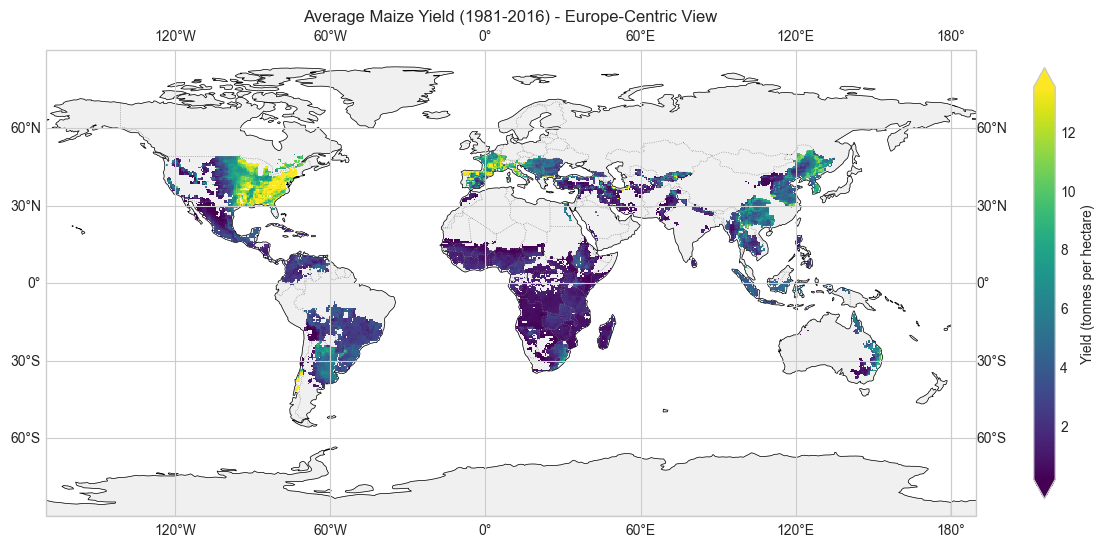

In [8]:
# Cell 5: Save the Average Yield Map

import os

# --- Configuration ---
# Define the output directory for our figures
output_dir = '../reports/figures/'
# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# --- Recreate the Plot (to make this cell self-contained) ---
# Create the figure and axes with a Cartopy projection centered on Europe
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})

# Style the map background
ax.add_feature(cfeature.LAND, edgecolor='lightgray', facecolor='#f0f0f0', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)
ax.coastlines(linewidth=0.5)

# Plot the data
mean_yield_map.plot(
    ax=ax,
    cmap='viridis',
    robust=True,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'shrink': 0.7, 'label': 'Yield (tonnes per hectare)'}
)

# Add gridlines and title
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title('Average Maize Yield (1981-2016) - Europe-Centric View')

# --- Save the Figure ---
file_path = os.path.join(output_dir, 'avg_maize_yield_1981-2016.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

print(f"Saved average map to: {file_path}")

# Display the plot in the notebook as well
plt.show()

In [9]:
# Cell 6: Save All Yearly Maps

# The output directory should already exist from the previous cell, but we'll be safe.
output_dir = '../reports/figures/yearly_maize/'
os.makedirs(output_dir, exist_ok=True)

# Use the same consistent color scale as before
vmin = maize_yield.quantile(0.02).compute().item()
vmax = maize_yield.quantile(0.98).compute().item()

print(f"Starting to save 36 yearly maps to '{output_dir}'...")

# Loop through each year in the dataset
for year in ds['time'].values:
    
    # Select the data for the current year
    yield_for_one_year = maize_yield.sel(time=year).where(maize_yield.sel(time=year) > 0)
    
    # Create a new figure and axes for each plot
    fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Style the map background
    ax.add_feature(cfeature.LAND, edgecolor='lightgray', facecolor='#f0f0f0', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)
    ax.coastlines(linewidth=0.5)

    # Plot the data
    yield_for_one_year.plot(
        ax=ax,
        cmap='viridis',
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={'shrink': 0.7, 'label': 'Yield (tonnes per hectare)'}
    )
    
    # Add title
    ax.set_title(f'Maize Yield in {year}')
    
    # --- Save the Figure for this year ---
    file_path = os.path.join(output_dir, f'maize_yield_{year}.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    
    # We close the plot to prevent it from displaying in the notebook output
    # This keeps the notebook clean and prevents it from getting too long.
    plt.close(fig)

print("Finished saving all yearly maps.")

Starting to save 36 yearly maps to '../reports/figures/yearly_maize/'...
Finished saving all yearly maps.
